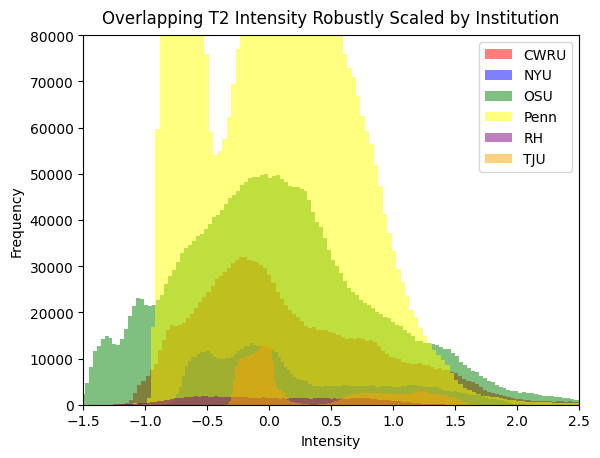

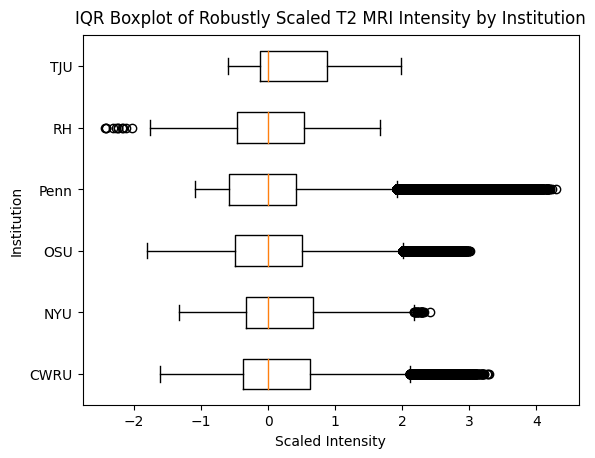

In [3]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import gzip
import shutil
import os
from sklearn.preprocessing import RobustScaler


# Directories for ADC and segmented images for each institution
institutions = {
    'CWRU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Baseline/',
             '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Seg/'),
    'NYU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/NYU/Baseline/',
            '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/NYU/Seg/'),
    'OSU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/OSU/Baseline/',
            '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/OSU/Seg/'),
    'Penn': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Penn/Baseline/',
             '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Penn/Seg/'),
    'RH': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/RH/Baseline/',
           '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/RH/Seg/'),
    'TJU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/TJU/Baseline/',
            '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/TJU/Seg/')
}

# Colors for each institution
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

# Bin size
bin_size = 150

all_institutions_scaled_adc_values = []

for index, (institution, paths) in enumerate(institutions.items()):
    baseline_dir, seg_dir = paths
    adc_gz_files = glob.glob(f"{baseline_dir}*t2*.gz")
    all_edema_adc_values = []

    for adc_gz_file in adc_gz_files:
        adc_file = adc_gz_file[:-3]  # Expected .nii file name after extraction

        if not os.path.exists(adc_file):
            with gzip.open(adc_gz_file, 'rb') as f_in:
                with open(adc_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

        file_name_parts = os.path.basename(adc_file).split('_')
        segmented_file_name = f"{file_name_parts[0]}_{file_name_parts[1]}_LPS_rSRI_segmF.nii"
        segmented_file = os.path.join(seg_dir, segmented_file_name)

        if not os.path.exists(segmented_file):
            segmented_gz_file = segmented_file + '.gz'
            if os.path.exists(segmented_gz_file):
                with gzip.open(segmented_gz_file, 'rb') as f_in:
                    with open(segmented_file, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)

        try:
            adc_img = nib.load(adc_file)
            segmented_img = nib.load(segmented_file)
            adc_data = adc_img.get_fdata()
            segmented_data = segmented_img.get_fdata()
            edema_adc_values = adc_data[segmented_data == 2]
            all_edema_adc_values.extend(edema_adc_values)

        except Exception as e:
            print(f"Error reading file {adc_file}: {e}")
            continue
    
         # Robust Scaling
    scaler = RobustScaler()
    scaled_adc_values = scaler.fit_transform(np.array(all_edema_adc_values).reshape(-1, 1)).flatten()
    all_institutions_scaled_adc_values.append(scaled_adc_values)

    # Plot the histogram for each institution after scaling
    plt.hist(scaled_adc_values, bins=bin_size, alpha=0.5, color=colors[index], label=institution)

plt.xlabel('Intensity')
plt.ylabel('Frequency')
# Set the upper limit of the x-axis
plt.xlim(left=-1.5, right=2.5)
plt.ylim(top=80000)
plt.legend()
plt.title('Overlapping T2 Intensity Robustly Scaled by Institution', y=1.01)
plt.show()

# Creating a boxplot for the scaled data
plt.figure()
plt.boxplot(all_institutions_scaled_adc_values, vert=0, labels=institutions.keys())
plt.ylabel('Institution')
plt.xlabel('Scaled Intensity')
plt.title('IQR Boxplot of Robustly Scaled T2 MRI Intensity by Institution', y=1.01)
plt.show()


